# Семинар 7 - Гауссова регрессия

  1. Напишем свой простейший GP
    * с RBF ядром
    * с Matern52 ядром
    * с цилиндрическим ядром
   2. сравним как они моделируют распределение
   3. презентуем GPy/GPytorch

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
EPS = 1e-10
sns.set()
warnings.filterwarnings("ignore")

def plot_gp(X_train, y_train, X_test, samples, mu, std):
    plt.figure(figsize=(12, 12))


    plt.plot(X_test, samples.T)

    plt.fill_between(X_test.ravel(), 
                     mu.ravel() - 2 * std.ravel(), 
                     mu.ravel() + 2 * std.ravel(), alpha=0.3)

    plt.plot(X_test, mu, 'r--', lw=2, label='Mean of GP')
    
    plt.scatter(X_train, y_train, s=30, label='Original data')

    plt.title('GP')

    plt.legend()

    plt.show()

## Распределения: совместные, условные, частные

Совместное распределение:

$$(x, y) \sim \mathcal{N}\left(\mu, \Sigma\right), ~\mu = [\mu_1, \mu_2], ~~\Sigma=\begin{bmatrix}\Sigma_{11} & \Sigma_{12} \\ \Sigma_{11}^T & \Sigma_{22} \end{bmatrix}$$

Частное:

$$x \sim  \mathcal{N}(\mu_1, \Sigma_{11})$$


Условное:

$$ (x | y) \sim \mathcal{N}(\mu_1 + \Sigma_{12} \Sigma_{22}^{-1}(y - \mu_2), \Sigma_{11} - \Sigma_{12} \Sigma_{22}^{-1} \Sigma_{12}^T)$$

In [2]:
parameters = {
    'mean': np.array([0., 0.]),
    'cov': np.array([[2., 1.5], 
                     [1.5, 2.]])
}

##### Совместное и частные распределения:

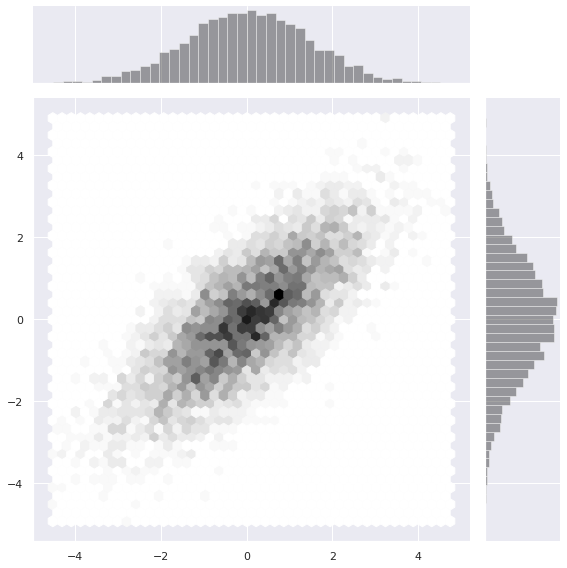

In [3]:
X_sample = np.random.multivariate_normal(size=5000, **parameters)
sns.jointplot(x=X_sample[:, 0], y=X_sample[:, 1], kind="hex", color="k", size=8);

##### Условные распределения:

In [4]:
y = np.linspace(-5, 5, 1000)

In [5]:
mu = parameters['mean'][0] + parameters['cov'][0, 1] * (y - parameters['mean'][1]) / parameters['cov'][1, 1]

var = parameters['cov'][0, 0] - parameters['cov'][0, 1]**2 / parameters['cov'][1, 1]

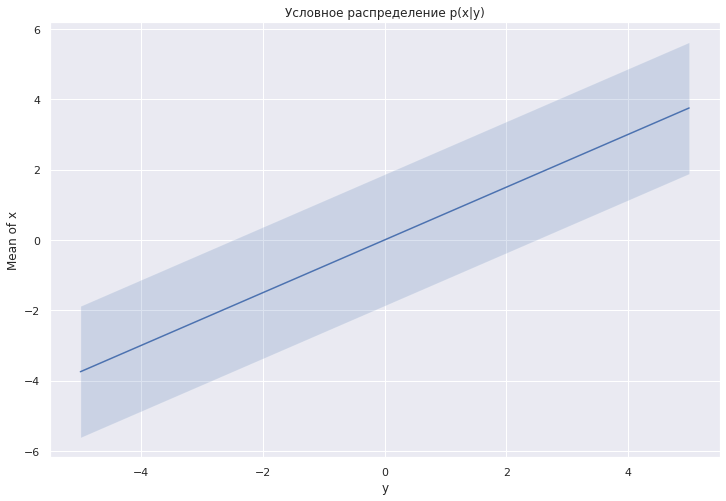

In [6]:
plt.figure(figsize=(12, 8))
plt.plot(y, mu)
plt.fill_between(y, mu - 2 * np.sqrt(var), mu + 2 * np.sqrt(var), alpha=0.2)
plt.title('Условное распределение p(x|y)')
plt.ylabel('Mean of x')
plt.xlabel('y')
plt.show()

### Ядра и, в частности, ~~пушечные~~ гауссовы

$$\mathrm{kern}: X \times X \rightarrow \mathbb{R} $$

Ядро это функция, которая отображает декартово произведение некоторого пространства с самим собой на действительную ось.

Больше инфы про ядра: http://www.machinelearning.ru/wiki/index.php?title=%D0%A4%D1%83%D0%BD%D0%BA%D1%86%D0%B8%D1%8F_%D1%8F%D0%B4%D1%80%D0%B0

#### Гауссово ядро

$$\mathrm{kern}(x, y) \sim \exp\left( -\frac{||x - y||_2}{2 \sigma^2} \right)$$

In [7]:
class GaussianKernel:
    def __init__(self, sigma: float):
        self.sigma = sigma
        
    def __call__(self, x1, x2):
        # l2-норма между матрицами x_train[N, K] y_train[M, K]
        # Выходом должна быть матрица [N, M]
        dist = (np.sum(x1**2, 1)[:, None] + 
                np.sum(x2**2, 1)[None, :] - 
                2 * x1.dot(x2.T)) 
        k = np.exp(- dist / self.sigma**2 / 2)
        return k

$$K\left(x, x^{\prime}\right)=\frac{\sigma_{f}^{2} 2^{1-\nu}}{\Gamma(\nu)}\left(\frac{\sqrt{2 \nu}\|x-x^{\prime}\|}{\rho}\right)^{\nu} K_{\nu}\left(\frac{\sqrt{2 \nu}\|x-x^{\prime}\|}{\rho}\right)$$

Для $$\nu=1 / 2: K\left(x, x^{\prime}\right)=\sigma_{f}^{2} \exp \left(-\|x-x^{\prime}\| / \rho\right)$$

In [8]:
from scipy.special import kv
from scipy.special import gamma
import math

class MaternKernel:
    def __init__(self, nu, rho):
        self.nu = nu
        self.rho = rho
    
    def __call__(self, x1, x2):
        x1 = x1 / self.rho
        x2 = x2 / self.rho
        dists = (
            np.sum(x1**2, 1)[:, None] + 
            np.sum(x2**2, 1)[None, :] - 
            2 * x1.dot(x2.T)
        )
        
        if self.nu == 0.5:
            K = np.exp(-dists)
        elif self.nu == 1.5:
            K = dists * math.sqrt(3)
            K = (1. + K) * np.exp(-K)
        elif self.nu == 2.5:
            K = dists * math.sqrt(5)
            K = (1. + K + K ** 2 / 3.0) * np.exp(-K)
        else:
            K = dists
            K[K == 0.0] += np.finfo(float).eps 
            tmp = (math.sqrt(2 * self.nu) * K)
            K.fill((2 ** (1. - self.nu)) / gamma(self.nu))
            K *= tmp ** self.nu
            K *= kv(self.nu, tmp)
        return np.nan_to_num(K)

[Cylindrical Kernels from ICML2018](https://icml.cc/Conferences/2018/ScheduleMultitrack?event=2230):

$$\begin{array}{ll}{T(\mathbf{x})=\left\{\begin{array}{ll}{\left(\|\mathbf{x}\|_{2}, \mathbf{x} /\|\mathbf{x}\|_{2}\right)} & {\text { for }\|\mathbf{x}\|_{2} \neq 0} \\ {\left(0, \mathbf{a}_{a r b i t r a r y}\right)} & {\text { for }\|\mathbf{x}\|_{2}=0}\end{array}\right.} \\ {T^{-1}(r, \mathbf{a})=r \mathbf{a}}\end{array}$$

$$\begin{aligned} K_{c y l}\left(\mathbf{x}_{1}, \mathbf{x}_{2}\right) &=\widetilde{K}\left(T\left(\mathbf{x}_{1}\right), T\left(\mathbf{x}_{2}\right)\right) \\ &=K_{r}\left(r_{1}, r_{2}\right) \cdot K_{a}\left(\mathbf{a}_{1}, \mathbf{a}_{2}\right) \end{aligned}$$

In [9]:
class CylindricalKernel:
    def __init__(self, angular_weights, radial_base_kernel, alpha=1., beta=1., eps=1e-9):
        self.angular_weights = angular_weights
        self.radial_base_kernel = radial_base_kernel
        self.alpha = alpha
        self.beta = beta
        self.eps = eps

    
    def __call__(self, x1, x2):
        x1 = x1.copy()
        x1[x1 == 0] = x1[x1 == 0] + self.eps
        r1 = np.linalg.norm(x1, axis=1, keepdims=True)
        
        x2 = x2.copy()
        x2[x2 == 0] = x2[x2 == 0] + self.eps
        r2 = np.linalg.norm(x2, axis=1, keepdims=True)

        if np.any(r1 > 1.0) or np.any(r2 > 1.0):
            raise RuntimeError("Cylindrical kernel not defined for data points with radius > 1. Scale your data!")

        a1, a2 = x1 / r1, x2 / r2
        
        dist = a1.dot(a2.T)
        angular_kernel = np.zeros_like(dist)
        for p in range(len(self.angular_weights)):
            angular_kernel += (dist**p) * self.angular_weights[p]
        
        radial_kernel = self.radial_base_kernel(self.kuma(r1), self.kuma(r2))
        
        return radial_kernel * angular_kernel

    def kuma(self, x):
        res = 1 - (1 - x**(self.alpha) + self.eps)**(self.beta)
        return res

### Причём здесь гауссовы процессы?

Пусть у нас есть выборка $X_{train}, y_{train}$ и есть $X_{test}$ для которых мы хотим построить вероятностную модель для $y_{test}$. А ещё мы выбрали некоторое ядро $\mathrm{kern}(\cdot, \cdot)$.

Тогда гауссова регрессия(гауссов процесс) записывается следующим образом:

$$p(X_{test}, y_{test}, X_{train}, y_{train}) = \mathcal{N}\left( 0 , \begin{bmatrix}K + \sigma^2 I & K_* \\ K_*^T & K_{**} \end{bmatrix} \right), $$

где

$$K = \mathrm{kern}(X_{train}, X_{train})$$

$$K_{*} = \mathrm{kern}(X_{train}, X_{test})$$

$$K_{**} = \mathrm{kern}(X_{test}, X_{test})$$

Т.е. матрица ковариаций это матрица ядра. Как мы увидим дальше, выбор ядра __очень важен__ и зависит от задачи.

Тогда наша задача это найти следующее распределение:

$$p(y_{test} | X_{test}, X_{train}, y_{train}) \sim \mathcal{N}\left(K_{*}^T (K + \sigma^2 I)^{-1} y_{train}, K_{**} - K_{*} (K + \sigma^2 I)^{-1} K_{*}^T\right)$$

In [10]:
# Noiseless training data
X_train = np.linspace(-5, 1, 40).reshape(-1, 1)
y_train = np.sin(2 * X_train) + X_train / 2 # + np.random.randn(*X_train.shape) / 2 + 

In [11]:
N = 1000
X_test = np.linspace(-8, 8, N).reshape(-1, 1)

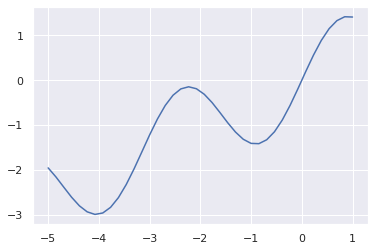

In [12]:
plt.plot(X_train[:, 0], y_train.ravel())

### Какое сейчас время? Время Гауссовой Регрессии!

In [13]:
class GaussianRegression:
    def __init__(self, kernel, X, y, noise=EPS):
        self.kernel = kernel
        self.X_train = X
        self.y_train = y
        self.noise = noise
        
        self.K_train = self.kernel(self.X_train, self.X_train)
        self.K_inv = np.linalg.pinv(self.K_train + self.noise * np.eye(len(X_train)))
    
    def predict(self, X_test):
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        # std
        std = np.sqrt(np.diag(cov))
        
        return mu.reshape((len(X_test), -1)), std.reshape((len(X_test), -1))
    
    def sample(self, X_test, n=1):
        # copy-paste code above
        
        # train-test kernel matrix
        k_train_test = self.kernel(self.X_train, X_test)
        
        # find mean(formules above)
        mu = np.dot(k_train_test.T, self.K_inv.dot(self.y_train))
        
        # find test-test kernel matrix
        K_test_test = self.kernel(X_test, X_test)
        
        # cov matrix
        cov = K_test_test - k_train_test.T.dot(self.K_inv.dot(k_train_test))
        
        samples = np.random.multivariate_normal(size=n, mean=mu.ravel(), cov=cov)
        
        return samples.T

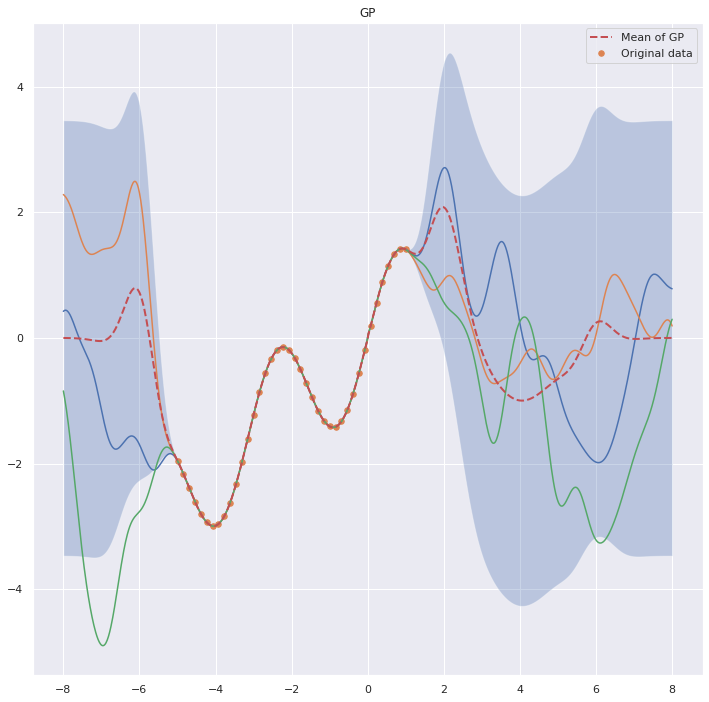

In [14]:
kernel = CylindricalKernel(angular_weights=np.array([1., 1., 1.]), radial_base_kernel=MaternKernel(nu=5/2, rho=0.1))
gregressor = GaussianRegression(kernel=kernel, X=X_train / 12, y=y_train, noise=1e-5)

mu, std = gregressor.predict(X_test / 12)
samples = gregressor.sample(X_test / 12, n=3).T

plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

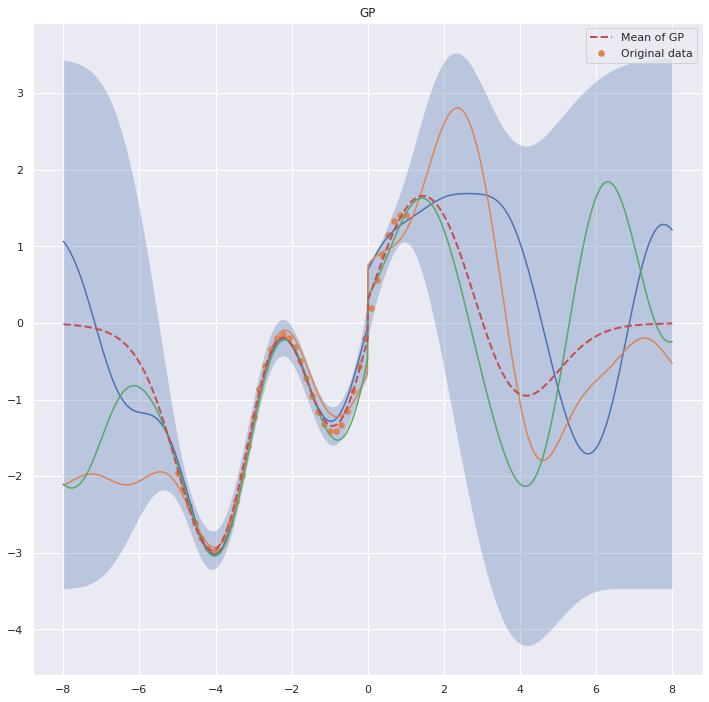

In [15]:
kernel = CylindricalKernel(angular_weights=np.ones(3), radial_base_kernel=GaussianKernel(sigma=0.1))
gregressor = GaussianRegression(kernel=kernel, X=X_train / 12, y=y_train, noise=1e-1)

mu, std = gregressor.predict(X_test / 12)
samples = gregressor.sample(X_test / 12, n=3).T

plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

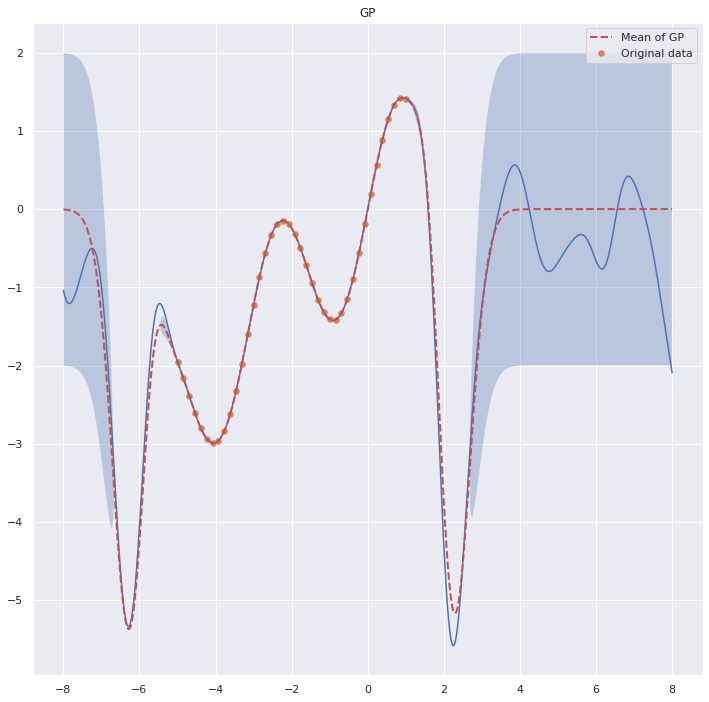

In [16]:
kernel = MaternKernel(nu=5/2, rho=0.1)
gregressor = GaussianRegression(kernel=kernel, X=X_train / 12, y=y_train, noise=1e-5)

mu, std = gregressor.predict(X_test / 12)
samples = gregressor.sample(X_test / 12).T

plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

## GPy

Чтобы не прогать самим и не делать кучу ошибок, лучше использовать готовые решения :)


In [17]:
import GPy

In [18]:
kern = GPy.kern.RBF(input_dim=1, lengthscale=1., variance=1.)

In [19]:
# kern.plot()

In [20]:
# нормальные ребята используют для регрессии GPRegression
# clf=GPy.models.GPRegression(X_train, y_train, kern)

In [21]:
X_train = X_train[::2]
y_train = y_train[::2]

In [22]:
# но нам и так нормально
clf=GPy.core.GP(X=X_train, 
                Y=y_train.reshape(-1, 1), 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=1e-2))

In [23]:
clf.optimize(messages=True)

In [24]:
mu, cov = clf.predict(X_test, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=3, mean=mu.ravel(), cov=cov)

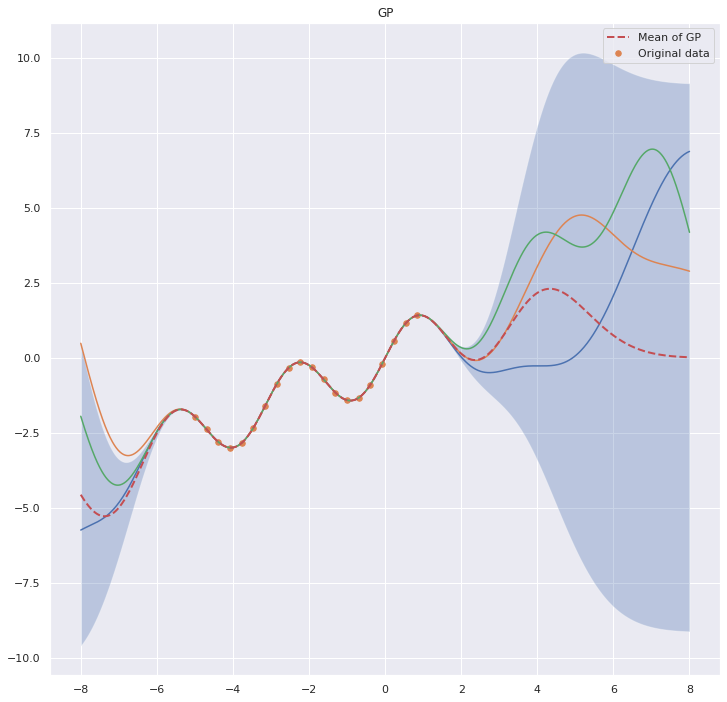

In [25]:
plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

### MOAR KERNELS

In [26]:
kern = GPy.kern.Poly(input_dim=1)

In [27]:
clf=GPy.core.GP(X=X_train, 
                Y=y_train.reshape(-1, 1), 
                kernel=kern, 
                likelihood=GPy.likelihoods.Gaussian(variance=2.))

In [28]:
clf.optimize(messages=True, optimizer='lbfgsb')

In [29]:
mu, cov = clf.predict(X_test, full_cov=True, include_likelihood=False)
std = np.sqrt(np.diag(cov))

samples = np.random.multivariate_normal(size=10, mean=mu.ravel(), cov=cov)

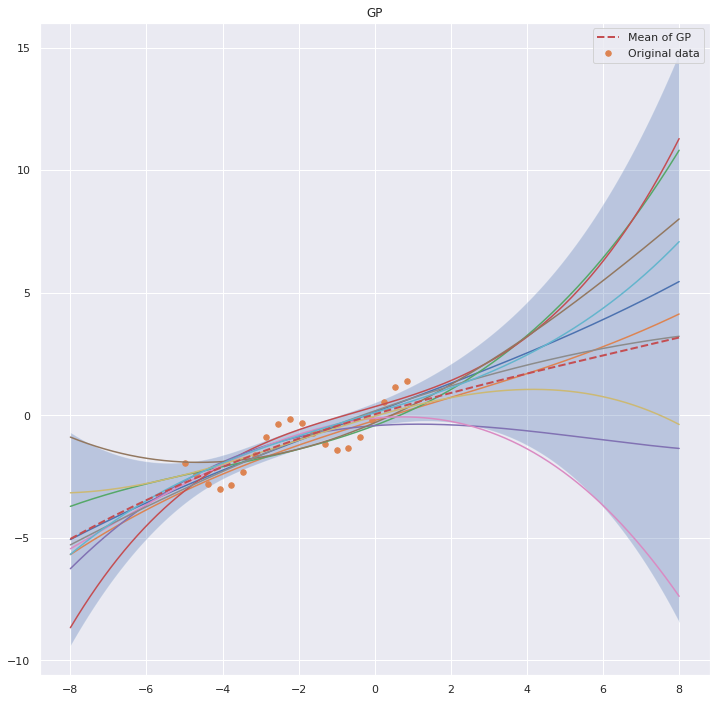

In [30]:
plot_gp(X_train=X_train[:, 0], y_train=y_train, 
        X_test=X_test[:, 0], samples=samples, mu=mu, std=std)

### Some "real data" 

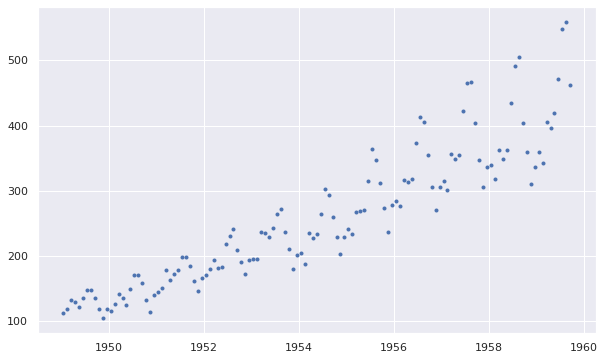

In [31]:
from scipy.io import loadmat

data = loadmat('airline.mat')

X = data['X']
y = data['y']

plt.figure(figsize=(10, 6))
plt.plot(X, y, '.')

In [32]:
def plot_model(X, y, kernel):
    model = GPy.models.GPRegression(X, y, kernel)
    model.optimize()
    print(model)
    
    x = np.linspace(1948, 1964, 400).reshape(-1, 1)
    prediction_mean, prediction_var = model.predict(x)
    prediction_std = np.sqrt(prediction_var).ravel()
    prediction_mean = prediction_mean.ravel()
    
    plt.figure(figsize=(10, 6))
    plt.plot(X, y, '.', label='Train data')
    plt.plot(x, prediction_mean, label='Prediction')
    plt.fill_between(x.ravel(), prediction_mean - prediction_std, prediction_mean + prediction_std, alpha=0.3)


Name : GP regression
Objective : 670.4420161378907
Number of Parameters : 3
Number of Optimization Parameters : 3
Updates : True
Parameters:
  GP_regression.           |               value  |  constraints  |  priors
  rbf.variance             |  255653.89947823348  |      +ve      |        
  rbf.lengthscale          |  16.622428255151046  |      +ve      |        
  Gaussian_noise.variance  |  1654.4810506550227  |      +ve      |        


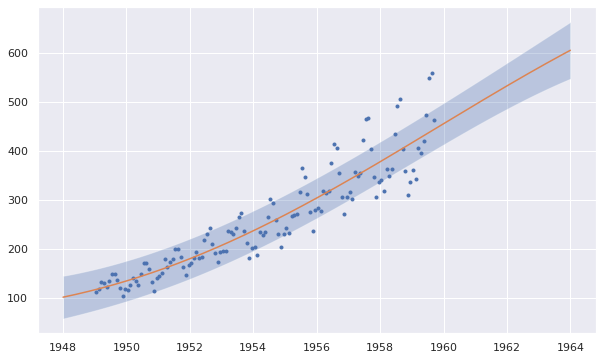

In [33]:
k_rbf = GPy.kern.RBF(1)
plot_model(X, y, k_rbf)

Мы попробуем моделировать данные как 3 аддитивные компоненты: тренд, сезонность и шум.

Поэтому ядро должно быть суммой трёх ядер:  
`kernel = kernel_trend + kernel_seasonality + kernel_noise`

#### Let's first try to model trend


Name : GP regression
Objective : 670.442016132413
Number of Parameters : 4
Number of Optimization Parameters : 4
Updates : True
Parameters:
  GP_regression.           |                   value  |  constraints  |  priors
  sum.linear.variances     |  5.562684646268137e-309  |      +ve      |        
  sum.rbf.variance         |      255639.74632466168  |      +ve      |        
  sum.rbf.lengthscale      |         16.622908919009  |      +ve      |        
  Gaussian_noise.variance  |       1654.471417678076  |      +ve      |        


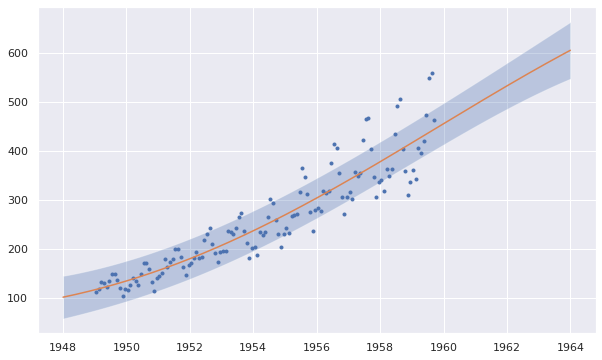

In [34]:
k_trend = GPy.kern.Linear(input_dim=1) + GPy.kern.RBF(input_dim=1)
plot_model(X, y, k_trend)

#### Let's model periodicity


Name : GP regression
Objective : 608.1082264946074
Number of Parameters : 8
Number of Optimization Parameters : 5
Updates : True
Parameters:
  GP_regression.                    |                   value  |  constraints  |  priors
  sum.linear.variances              |  5.562684646268137e-309  |      +ve      |        
  sum.rbf.variance                  |      29998.841065596815  |      +ve      |        
  sum.rbf.lengthscale               |      2.4543404205475547  |      +ve      |        
  sum.mul.std_periodic.variance     |                     1.0  |   +ve fixed   |        
  sum.mul.std_periodic.period       |                     1.0  |   +ve fixed   |        
  sum.mul.std_periodic.lengthscale  |                     1.0  |   +ve fixed   |        
  sum.mul.linear.variances          |     0.00983624246957136  |      +ve      |        
  Gaussian_noise.variance           |      432.62804997072055  |      +ve      |        


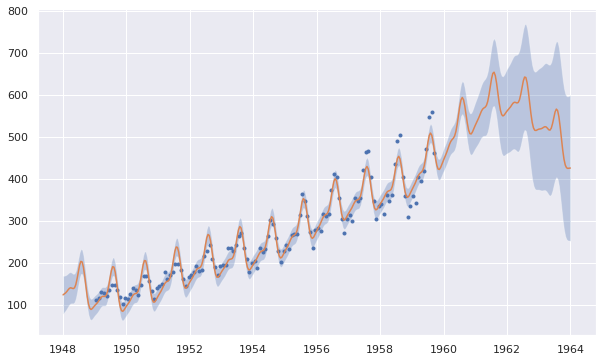

In [35]:
k_trend = GPy.kern.Linear(input_dim=1) + GPy.kern.RBF(input_dim=1, lengthscale=1)
periodic_kern = GPy.kern.StdPeriodic(input_dim=1, lengthscale=1)
periodic_kern.fix()
k_seasonal = periodic_kern * GPy.kern.Linear(input_dim=1)
kernel = k_trend + k_seasonal
plot_model(X, y, kernel)

Let's add noise model.
`GPy.kern.White()` kernel models noise at training points: $k_{white}(x, x') = \delta(x - x')$


Name : GP regression
Objective : 503.1405350572585
Number of Parameters : 14
Number of Optimization Parameters : 14
Updates : True
Parameters:
  GP_regression.                    |                   value  |  constraints  |  priors
  sum.poly.variance                 |  3.0880426622152733e-06  |      +ve      |        
  sum.poly.scale                    |   3.088057834607941e-06  |      +ve      |        
  sum.poly.bias                     |      0.9999974078574975  |      +ve      |        
  sum.rbf.variance                  |      100.12905525936287  |      +ve      |        
  sum.rbf.lengthscale               |      0.5536288261297236  |      +ve      |        
  sum.mul.std_periodic.variance     |     0.25266532701270633  |      +ve      |        
  sum.mul.std_periodic.period       |      1.0026748701598955  |      +ve      |        
  sum.mul.std_periodic.lengthscale  |      0.5320984419042312  |      +ve      |        
  sum.mul.linear.variances          |      0.2526653205

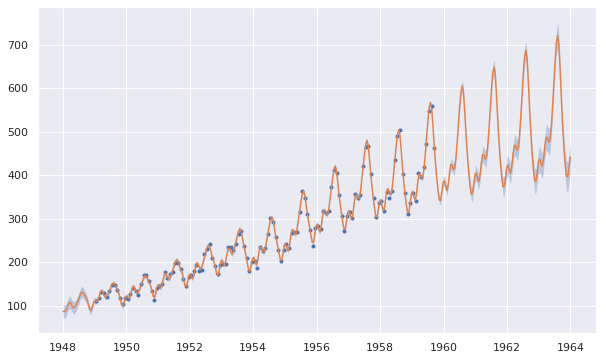

In [36]:
k_trend = GPy.kern.Poly(1, order=1) + GPy.kern.RBF(1)
k_periodicity = GPy.kern.StdPeriodic(1) * GPy.kern.Linear(1) * GPy.kern.RBF(1)
k_noise = GPy.kern.White(1) * GPy.kern.Linear(1)
kernel = k_trend + k_periodicity + k_noise

plot_model(X, y, kernel)

## Multiple Inputs Example
$$f(x1,x2)=\sin(x1) \sin(x2)$$
$$y=f(X)+\varepsilon; \varepsilon \sim \mathcal{N}(0,\sigma^2)$$

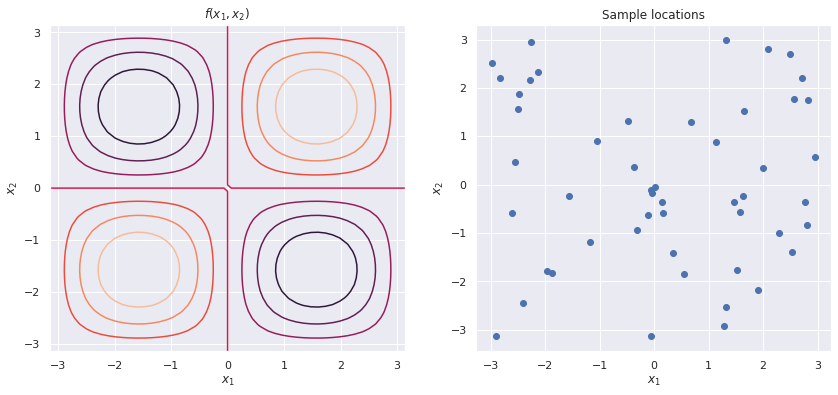

In [37]:
# Lambda function, f, the unknown function we are trying to predict
f = lambda xi,xj: np.sin(xi) * np.sin(xj)

# Our test grid
[Xi, Xj] = np.meshgrid(np.linspace(-np.pi, np.pi, 50), np.linspace(-np.pi, np.pi, 50))

# Number of samples [YOU CAN PLAY AROUND WITH THE NUMBER OF RANDOM SAMPLES TO SEE HOW THE FIT IS AFFECTED]
num_measurements = 50

# Random sample locations (2-D)
X2 = np.random.uniform(-np.pi, np.pi, (num_measurements, 2))

# Setup plot enviornment
plt.figure(figsize=(14, 6))

plt.subplot(121)
# Show true function
plt.contour(Xi, Xj, f(Xi, Xj))
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("$f(x_1,x_2)$")

plt.subplot(122)
# Show sample locations
plt.plot(X2[:, 0], X2[:, 1],'o')
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Sample locations");

In [38]:
Y2 = np.array([f(x1,x2) for (x1,x2) in zip(X2[:,0], X2[:,1])])[:,None] + 0.05 * np.random.randn(X2.shape[0], 1)

GP_regression.,value,constraints,priors
rbf.variance,0.22249436434540787,+ve,
rbf.lengthscale,1.364467076858466,+ve,
Gaussian_noise.variance,0.05,+ve fixed,


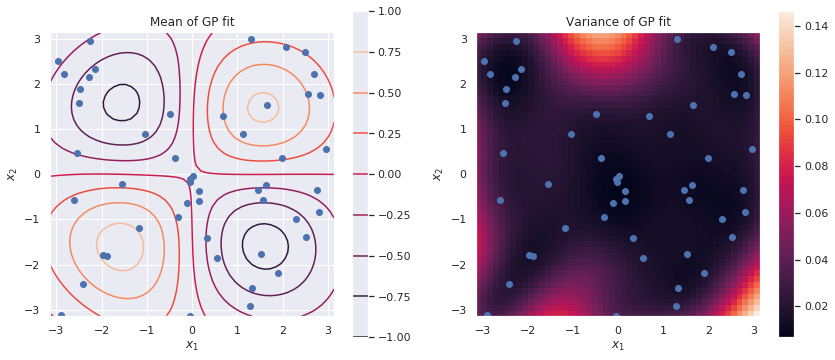

In [39]:
# Create a 2-D RBF kernel active over both input dimensions
k = GPy.kern.RBF(2, active_dims=[0,1])

# Create a GP Regression model with the sample locations and observations using the RBF kernel
m = GPy.models.GPRegression(X2, Y2, k)

# Fix the Gaussian noise variance, which we know
m.Gaussian_noise.variance = 0.05 
m.Gaussian_noise.variance.fix()

# Optimise the kernel parameters
m.optimize()

# We need to augument our test space to be a list of coordinates for input to the GP
Xnew2 = np.vstack((Xi.ravel(), Xj.ravel())).T # Change our input grid to list of coordinates

# Predict the mean and covariance of the GP fit at the test locations
mean2, Cov2 = m.predict_noiseless(Xnew2, full_cov=False)

# Setup plot environment
plt.figure(figsize=(14, 6))

# Left plot shows mean of GP fit
plt.subplot(121)

# Plot mean surface
plt.contour(Xi, Xj, mean2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Mean of GP fit"), plt.colorbar()

# Right plot shows the variance of the GP
plt.subplot(122)    
# Plot variance surface
plt.pcolor(Xi, Xj, Cov2.reshape(Xi.shape))
# Show sample locations
plt.plot(X2[:,0],X2[:,1],'o'), plt.axis("square")
# Annotate plot
plt.xlabel("$x_1$"), plt.ylabel("$x_2$")
plt.title("Variance of GP fit"), plt.colorbar()

# Preview GP model parameters
m